<p style = 'font-size:40px'> <strong>Integrating Python and Oracle Databases</strong></p>

<p style = 'font-size:30px'> <strong> Introduction</strong> </p>

* <p style = 'font-size:20px'> The goal of this project is to demonstrate Python's capability to interact with Oracle Databases through the usage of cx_Oracle library. </p>
* <p style = 'font-size:20px'> To do this, I have simulated a situation in which I work for a hardware selling company that needs to get a variety of data about its performance. My role is to get access to the company's Oracle database in order to get the information demanded. </p>
* <p style = 'font-size:20px'> You can find the user's table diagram below: </p>

<img src='database.png'>

<p style = 'font-size:30px'> <strong>Project's tasks</strong> </p>

<p style = 'font-size:20px'> 1) Obtain the level of storage of each of the company's warehouses.  </p>
<p style = 'font-size:20px'> 2) List the most prolific salespeople. </p>
<p style = 'font-size:20px'> 3) Point out the product with most units sold for each of the company's customers. </p>
<p style = 'font-size:20px'> 4) Get the annual revenue per product category.  </p>
<p style = 'font-size:20px'> 5) Increase all CPU products price by 10%. </p>

<p style = 'font-size:30px'><strong>Connecting to the company's data</strong></p>

In [1]:
# Firstly we need to inform some informations about the Data Source Name (DSN)
# We are going to create a variable that stores all the informations related to our DSN
# You must pass the host name, the port number and the service name of the database

import cx_Oracle
dsn = cx_Oracle.makedsn('localhost.localdomain', 1521, service_name = 'orcl')

In [2]:
# Now, we are going to connect us to the user in which the demanded data can be find. Its name is 'OT'.
# If you are uncomfortable in with displaying the user's password in your code, you can use the getpass object from thet 
                                                                                                            #getpass library.

from getpass import getpass
password  = getpass('Write your database password:')

connection = cx_Oracle.connect('OT', password, dsn = dsn)

Write your database password: ······


<p style = 'font-size:30px'> <strong> Now let's get our data! </strong></p>

<p style = 'font-size:30px'> <em> Task 1 <span style = 'font-size:15px'>Obtain the storage level of each of the company's warehouses. </span></em> </p>

In [3]:
# Since the company has 8 warehouses, we are going to create a subplots figure. Each subplot will present the storage levels for
                                                                                                                    # each warehouse

# We also are going to create a list containg the position of each subplot in our figure.
l = [(i,j) for i in range(2) for j in range(4)]
print(l)

[(0, 0), (0, 1), (0, 2), (0, 3), (1, 0), (1, 1), (1, 2), (1, 3)]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


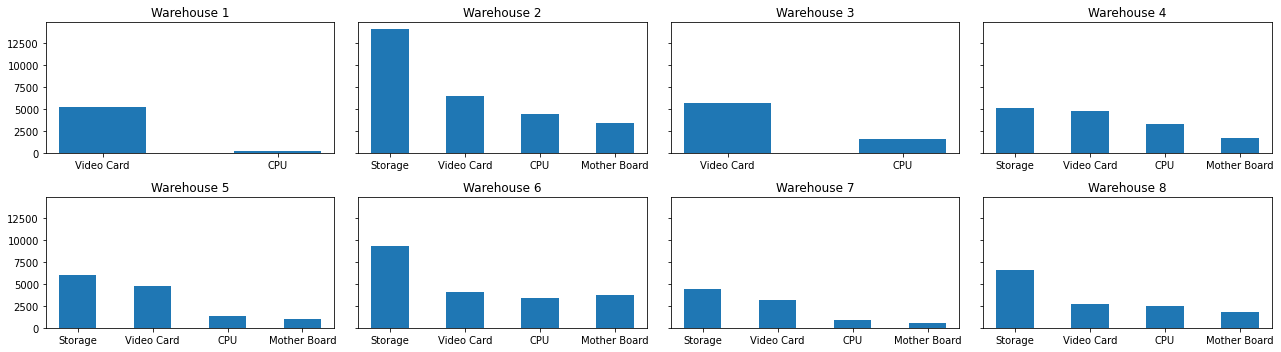

In [6]:
# Now, we are going to iterate over that list and plot the storage level for each product category available.
# We are going to use the enumerate method so we can take advantage of the list's indices to perform our queries.
import matplotlib.pyplot as plt
import pandas as pd
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(18,5), sharey=True)

for i, position in enumerate(l):
      
    query = f'''SELECT I.WAREHOUSE_ID, PC.CATEGORY_NAME, SUM(I.QUANTITY)
    FROM PRODUCT_CATEGORIES PC, PRODUCTS P, INVENTORIES I
    WHERE P.CATEGORY_ID=PC.CATEGORY_ID
    AND P.PRODUCT_ID=I.PRODUCT_ID
    AND WAREHOUSE_ID={i+1}
    GROUP BY I.WAREHOUSE_ID, PC.CATEGORY_NAME
    '''
    # Each time our query is run, pandas will create a DataFrame that contains the storage levels for each warehouse.
    table = pd.read_sql(query, connection)
    # We are going to use the table's information to plot a chart for every single warehouse.
    ax[position].bar(table['CATEGORY_NAME'], table['SUM(I.QUANTITY)'],width=0.5)
    ax[position].set_title(f'Warehouse {i+1}') 

plt.tight_layout()
fig.show()

<p style = 'font-size:30px'>  <em>Task 2 </em> <span style = 'font-size:15px'>List the most prolific salespeople. </span> </p>

<BarContainer object of 9 artists>

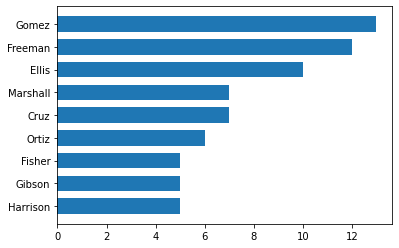

In [7]:
# This is a simple task: we must perform a join among the tables ORDERS and EMPLOYEES followed by a GROUP BY 
query = ''' SELECT E.LAST_NAME, COUNT(O.ORDER_ID) TOTAL_SALES
            FROM ORDERS O, EMPLOYEES E
            WHERE O.SALESMAN_ID = E.EMPLOYEE_ID
            GROUP BY O.SALESMAN_ID, E.LAST_NAME
            ORDER BY TOTAL_SALES ASC
            '''
# The pandas DataFrame obtained will contain the surname and the amount of sales made by a certain salesperson.
salesman = pd.read_sql(query, connection)
y = salesman['LAST_NAME']
x = salesman['TOTAL_SALES']
plt.barh(y,x, height = 0.68)

<p style = 'font-size:30px'> <em> Task 3 </em> <span style = 'font-size:15px'>Point out the product category with most units sold for each of the company's customers. </span>  </p>

In [8]:
# This task will demand us a big join operation in order to unite the companies' names, the product categories they consume and the
# total quantity bought in a single table.
# The query below will give us the name of each of the company's customers along with the products categories they buy and their
                                                                                                # respective quantity 
query = '''SELECT C.NAME, PC.CATEGORY_NAME, SUM(OI.QUANTITY) TOTAL_QUANTITY
FROM ORDER_ITEMS OI, ORDERS O, CUSTOMERS C, PRODUCTS P, PRODUCT_CATEGORIES PC
WHERE OI.ORDER_ID=O.ORDER_ID
AND O.CUSTOMER_ID = C.CUSTOMER_ID
AND OI.PRODUCT_ID = P.PRODUCT_ID  
AND P.CATEGORY_ID=PC.CATEGORY_ID
GROUP BY (C.NAME, PC.CATEGORY_NAME)
ORDER BY C.NAME
'''

c_o_info = pd.read_sql(query, connection, index_col=['NAME'])
# We need to perform a second group operation on pandas to get the data demanded. This would be simpler than making the whole process
                                                                                                                # on Oracle.
c_o_info.groupby([c_o_info.index])['CATEGORY_NAME','TOTAL_QUANTITY'].max()

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


,CATEGORY_NAME,TOTAL_QUANTITY
NAME,,
AECOM,Storage,287
AbbVie,Video Card,827
Abbott Laboratories,Video Card,503
Aflac,Video Card,1351
Alcoa,Video Card,1512
American Electric Power,Storage,500
AutoNation,Video Card,823
AutoZone,Video Card,235
Baker Hughes,Video Card,207


<p style = 'font-size:30px'> <em> Task 4</em> <span style = 'font-size:15px'>Get the annual revenue per product category. </span> </p>

In [9]:
# This query is a bit tricky: firstly, we need to make a join operation that returns a daily report on the revenue obtained from
# the sellings of each product categories.
query = ''' SELECT O.ORDER_DATE, PC.CATEGORY_NAME, SUM(OI.UNIT_PRICE * OI.QUANTITY) REVENUE
            FROM ORDER_ITEMS OI, ORDERS O, PRODUCTS P, PRODUCT_CATEGORIES PC
            WHERE PC.CATEGORY_ID = P.CATEGORY_ID
            AND P.PRODUCT_ID = OI.PRODUCT_ID
            AND O.ORDER_ID = OI.ORDER_ID
            GROUP BY PC.CATEGORY_NAME, O.ORDER_DATE
            ORDER BY O.ORDER_DATE
'''


revenue = pd.read_sql(query, connection,parse_dates = True, index_col = ['ORDER_DATE'])
# To get the annual data, we have to convert the DataFrame's index to a Period with yearly frequency.
revenue.index = revenue.index.to_period('Y')
# After it, we must perform a groupby operation on pandas to sum each product categories revenue based on the year shown in the index.
revenue = revenue.groupby([revenue.index, 'CATEGORY_NAME']).sum()
display(revenue)

REVENUE
ORDER_DATE CATEGORY_NAME            
2013       CPU             243447.75
           Storage         270820.16
2015       CPU            3365931.32
           Mother Board    598459.65
           Storage        2170320.55
           Video Card     2689065.10
2016       CPU            8602324.95
           Mother Board   2101448.44
           Storage        5997806.79
           Video Card     4788025.92
2017       CPU            7830289.01
           Mother Board   2218510.06
           Storage        5555213.34
           Video Card     6310429.60